# Churn Prediction Model – Subscription Analytics Project

This notebook builds a logistic regression model to predict customer churn 
using subscription history, payment behavior, and engagement metrics.


In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [3]:
users = pd.read_csv("../Data/users.csv")
subscriptions = pd.read_csv("../Data/subscriptions.csv")
payments = pd.read_csv("../Data/payments.csv")
activity = pd.read_csv("../Data/user_activity.csv")

In [4]:
subscriptions.head()
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7570 entries, 0 to 7569
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subscription_id  7570 non-null   int64  
 1   user_id          7570 non-null   int64  
 2   plan             7570 non-null   object 
 3   monthly_price    7570 non-null   float64
 4   start_date       7570 non-null   object 
 5   end_date         1939 non-null   object 
 6   status           7570 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 414.1+ KB


In [5]:
subscriptions['churn'] = subscriptions['status'].apply(
    lambda x: 1 if str(x).lower() == 'canceled' else 0
)

subscriptions['churn'].value_counts()

churn
0    5631
1    1939
Name: count, dtype: int64

In [6]:
subscriptions['start_date'] = pd.to_datetime(subscriptions['start_date'])
subscriptions['end_date'] = pd.to_datetime(subscriptions['end_date'])

subscriptions['subscription_length'] = (
    subscriptions['end_date'] - subscriptions['start_date']
).dt.days

sub_features = subscriptions.groupby('user_id').agg({
    'subscription_length': 'sum',
    'monthly_price': 'mean',
    'churn': 'max'
}).reset_index()

sub_features.head()

,user_id,subscription_length,monthly_price,churn
0,1,0.0,11.656667,0
1,2,100.0,9.990000,1
2,3,173.0,19.990000,1
3,4,98.0,19.990000,1
4,5,0.0,14.990000,0


In [7]:
payment_features = payments.groupby('user_id').agg({
    'amount': ['count', 'sum', 'mean']
}).reset_index()

payment_features.columns = [
    'user_id',
    'payment_count',
    'total_revenue',
    'avg_payment'
]

payment_features.head()

,user_id,payment_count,total_revenue,avg_payment
0,1,24,309.76,12.906667
1,2,27,269.73,9.990000
2,3,6,119.94,19.990000
3,4,4,79.96,19.990000
4,5,32,479.68,14.990000


In [8]:
activity['activity_date'] = pd.to_datetime(activity['activity_date'])

In [9]:
activity_features = activity.groupby('user_id').agg({
    'watch_time_minutes': ['count', 'sum', 'mean']
}).reset_index()

activity_features.columns = [
    'user_id',
    'active_days',
    'total_watch_time',
    'avg_watch_time_per_day'
]

activity_features.head()

,user_id,active_days,total_watch_time,avg_watch_time_per_day
0,1,98,3204.03,32.694184
1,2,45,1705.85,37.907778
2,3,59,1933.21,32.766271
3,4,33,1008.97,30.574848
4,5,40,1180.99,29.524750


In [10]:
df_model = sub_features.merge(payment_features, on='user_id', how='left')
df_model = df_model.merge(activity_features, on='user_id', how='left')

df_model.fillna(0, inplace=True)

df_model.head()

,user_id,subscription_length,monthly_price,churn,payment_count,total_revenue,avg_payment,active_days,total_watch_time,avg_watch_time_per_day
0,1,0.0,11.656667,0,24,309.76,12.906667,98,3204.03,32.694184
1,2,100.0,9.990000,1,27,269.73,9.990000,45,1705.85,37.907778
2,3,173.0,19.990000,1,6,119.94,19.990000,59,1933.21,32.766271
3,4,98.0,19.990000,1,4,79.96,19.990000,33,1008.97,30.574848
4,5,0.0,14.990000,0,32,479.68,14.990000,40,1180.99,29.524750


In [11]:
X = df_model.drop(['user_id', 'churn', 'subscription_length'], axis=1)
y = df_model['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [13]:
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 69 161]
 [ 46 324]]
              precision    recall  f1-score   support

           0       0.60      0.30      0.40       230
           1       0.67      0.88      0.76       370

    accuracy                           0.66       600
   macro avg       0.63      0.59      0.58       600
weighted avg       0.64      0.66      0.62       600



In [14]:
y_probs = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_probs)

print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.7493654524089306


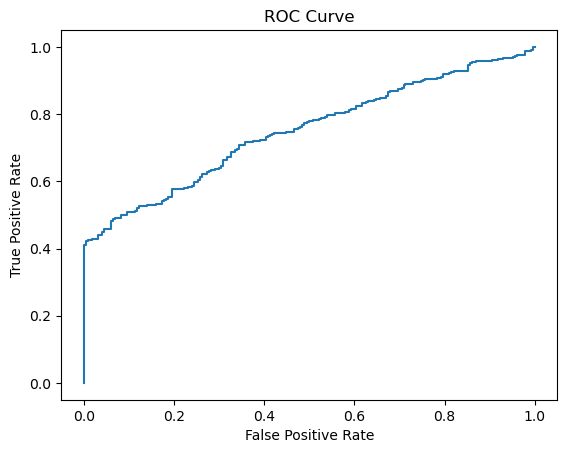

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [16]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})

coefficients.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
3,avg_payment,0.071761
6,avg_watch_time_per_day,0.011056
5,total_watch_time,0.000002
2,total_revenue,-0.000779
4,active_days,-0.003306
1,payment_count,-0.044881
0,monthly_price,-0.045076


## Business Insights

• Users with shorter subscription lengths show significantly higher churn probability.

• Lower activity levels strongly correlate with churn risk.

• Customers generating lower total revenue tend to cancel more frequently.

• Engagement and revenue behavior are strong predictors of retention.


## Final Model Performance

ROC-AUC: 0.75

The model demonstrates moderate predictive power.
Engagement and payment behavior are meaningful predictors of churn.
